In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader

Data loading

In [11]:
df = pd.read_csv('train_data.txt', sep=":::", header=None, engine='python')
df = df.drop(0, axis=1)
df.columns = ["name", "class", "description"]
df.head()

,name,class,description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


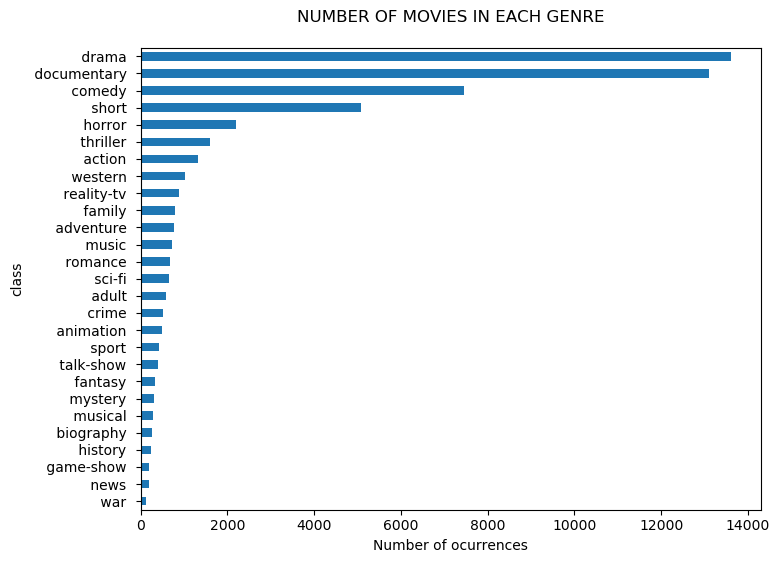

In [12]:
fig = plt.figure(figsize=(8,6))
df["class"].value_counts().sort_values().plot.barh(
    ylim=0, title= 'NUMBER OF MOVIES IN EACH GENRE\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

Data preprocessing

In [13]:
genres = df["class"].value_counts().index.tolist()

df = df.sample(frac=1)

df_filtered = pd.DataFrame(columns=["name", "class", "description"])
for genre in genres:
  df_filtered = pd.concat([df_filtered, df[df['class'].str.contains(genre)].head(10000)], axis=0)

df = df_filtered.copy()
df.head()

,name,class,description
11904,Buddha's Little Finger (2015),drama,Unemployed Russian poet Pyotr Voyd arrested b...
19680,Shooting Bernarda (2018),drama,"When her husband dies, BERNARDA, a wealthy an..."
1230,After the Tone (2014),drama,"We hear voice-mail messages, recorded on the ..."
772,El bruto (1953),drama,"In the 50's, in a poor community in Mexico, t..."
11210,Svetat e golyam i spasenie debne otvsyakade (...,drama,"What's in a game? For a young man, who has le..."


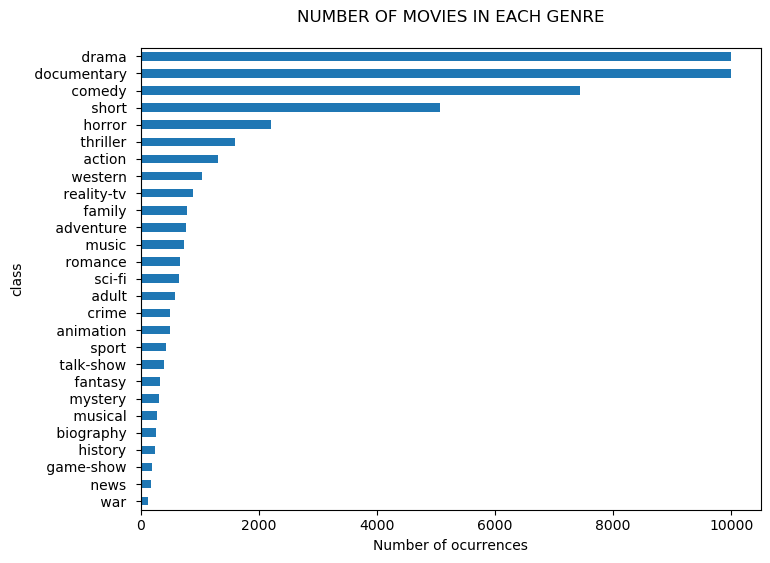

In [14]:
fig = plt.figure(figsize=(8,6))
df["class"].value_counts().sort_values().plot.barh(
    ylim=0, title= 'NUMBER OF MOVIES IN EACH GENRE\n')
plt.xlabel('Number of ocurrences', fontsize = 10)

In [15]:
df['genre_id'] = df['class'].factorize()[0]
category_id_df = df[['class', 'genre_id']].drop_duplicates()
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['genre_id', 'class']].values)

Classification pipeline

In [16]:
X = df_filtered['description'] # Collection of documents
y = df_filtered['class'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 20)

In [20]:
text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1, 3), stop_words = 'english')),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC())
])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names = df['class'].unique(), zero_division=1)) 

               precision    recall  f1-score   support

       drama        0.46      0.35      0.39       260
 documentary        0.69      0.41      0.52       119
      comedy        0.59      0.22      0.32       148
       short        0.56      0.10      0.17        93
      horror        1.00      0.00      0.00        53
    thriller        0.56      0.61      0.59      1506
      action        0.60      0.03      0.05       106
     western        0.63      0.88      0.74      2011
  reality-tv        0.51      0.74      0.60      2020
      family        0.53      0.10      0.17       173
   adventure        0.00      0.00      0.00        63
       music        0.81      0.70      0.75        37
     romance        1.00      0.00      0.00        49
      sci-fi        0.58      0.74      0.65       434
       adult        0.57      0.57      0.57       126
       crime        0.38      0.07      0.12        42
   animation        0.50      0.03      0.05        69
       sp

Text(0.5, 80.7222222222222, 'Predicted')

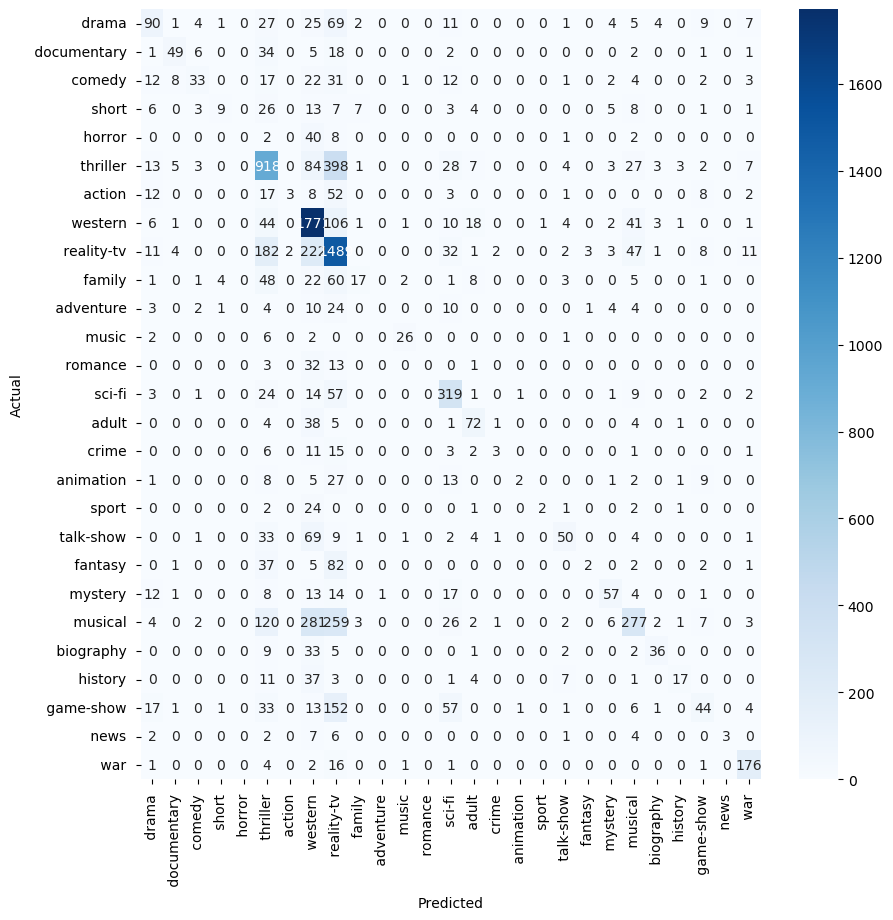

In [18]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot = True, cmap = "Blues", fmt = 'd',
            xticklabels = category_id_df["class"].values,
            yticklabels = category_id_df["class"].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')